In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

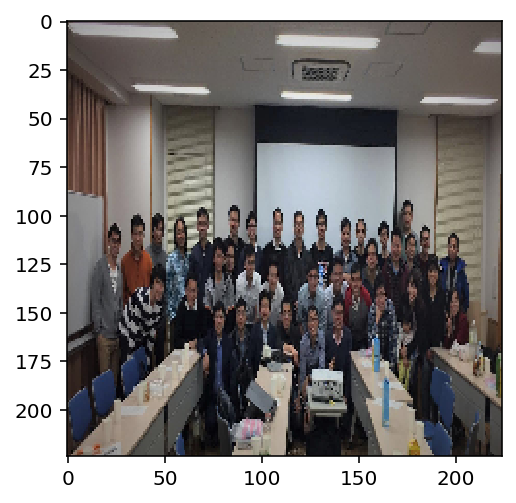

In [2]:
img = Image.open('vjai_1.jpg')
preprocess = transforms.Compose([transforms.Resize((224,224),interpolation=Image.NEAREST),
                                 #transforms.Resize(256),
                                 #transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                ])
img_tensor = preprocess(img)[None,:,:,:]
plt.imshow(img_tensor[0].detach().numpy().transpose(1,2,0))

In [ ]:
img_tensor.shape

In [3]:
import json 

with open('imagenet_class_index.json') as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
    
import torch
import torch.nn as nn
from torchvision.models import resnet152
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None])/ self.std.type_as(x)[None,:,None,None]

norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [4]:
def plot_figure(input_img, predict, correct_class=None, target_class=None, pars=None, img_name='Image', fig_show=1):
    #p = sess.run(probs, feed_dict={image: img})[0]
    img = input_img[0].detach().numpy().transpose(1,2,0)
    p = nn.Softmax(dim=1)(predict)[0,:]
    p = p.detach().numpy()
    predicted_id = int(p.argsort()[-1:][::-1])
    predicted_probability = p[predicted_id]
    if(fig_show):
        plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        fig.sca(ax1)

        ax1.imshow(img)
        fig.sca(ax1)
        plt.title(img_name)
        topk = list(p.argsort()[-5:][::-1])

        #print(predicted_probability)
        topprobs = p[topk]
        barlist = ax2.bar(range(5), topprobs)
        if target_class in topk:
            barlist[topk.index(target_class)].set_color('r')
        if correct_class in topk:
            barlist[topk.index(correct_class)].set_color('g')

        plt.sca(ax2)
        plt.ylim([0, 1.1])
        plt.xticks(range(5),
                    [imagenet_classes[i][:16] for i in topk],
                    rotation=80)


        fig.subplots_adjust(bottom=0.2)
        plt.show()
        for rect in barlist:
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,'%0.3f' % float(height), ha='center', va='bottom')
        if pars:
            plt.title('epsilon: '+str(pars[0])+', learning rate: '+str(pars[1])+', iteration: '+str(pars[2])+', Elapsed time (s): '+str(pars[3]))

    return predicted_id,predicted_probability

In [5]:
import math
model = resnet152(pretrained=True)
model.eval()
pred = model(norm(img_tensor))
predit_id = pred.max(dim=1)[1].item()
loss = nn.CrossEntropyLoss()(model(norm(img_tensor)),torch.LongTensor([predit_id])).item()
print('predict label: {}, loss: {:.5f}, probability: {:.2f}'.format(imagenet_classes[predit_id], loss,math.exp(-loss)))

predict label: balance_beam, loss: 0.05144, probability: 0.95


<Figure size 432x288 with 0 Axes>

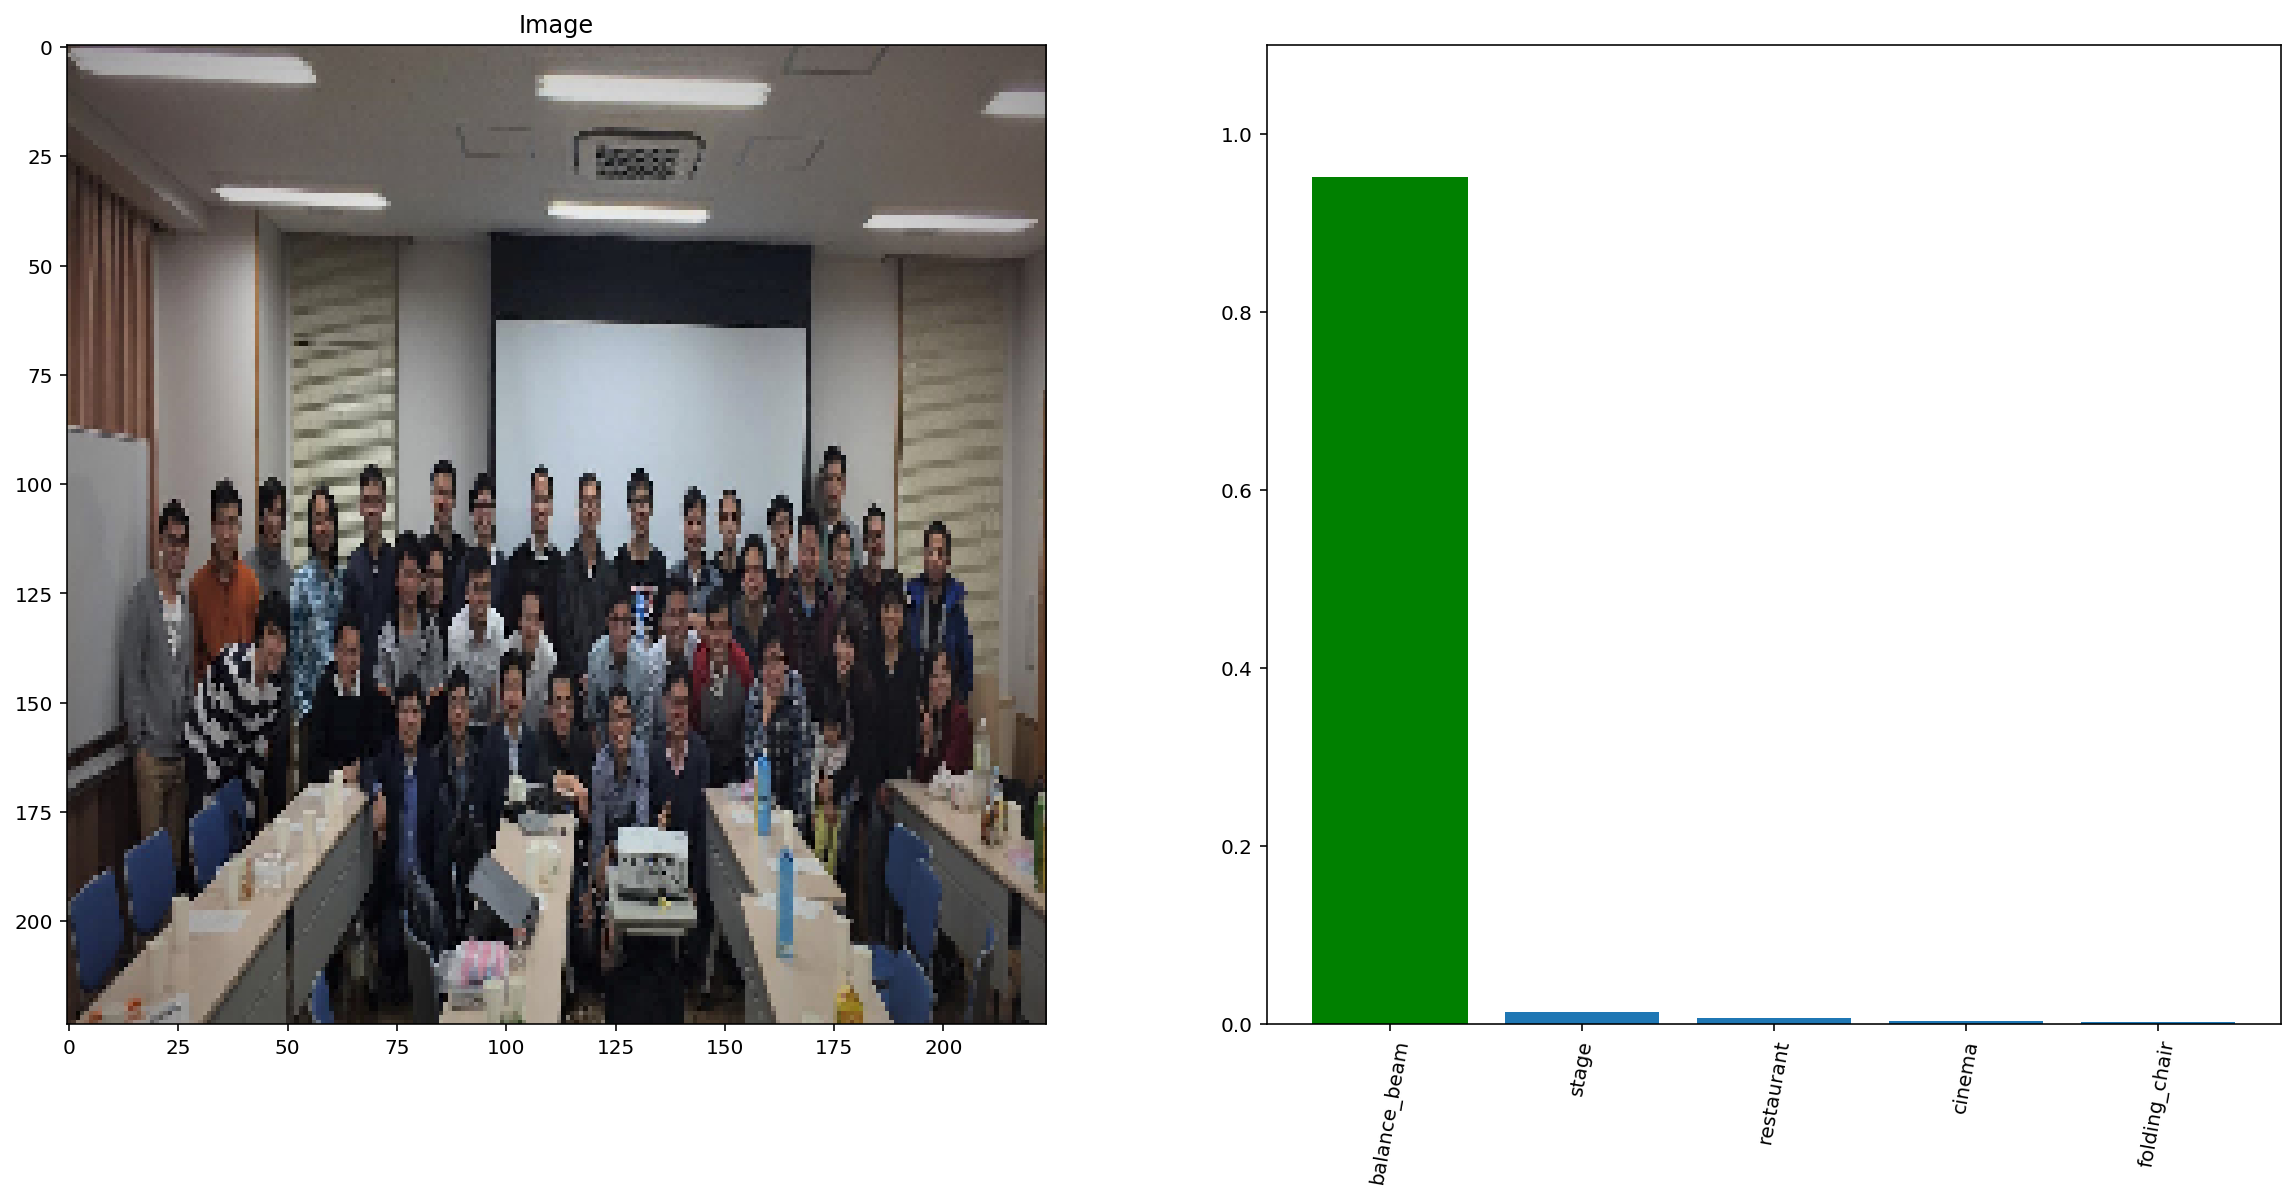

(416, 0.9498611)

In [6]:
plot_figure(img_tensor, pred, correct_class=predit_id, target_class=111, pars=None, img_name='Image')

# Untargeted Adversarial Attack

In [7]:
import torch.optim as optim
import copy
epsilon = 4./255
delta = torch.zeros_like(img_tensor, requires_grad=True)
opt = optim.Adam([delta], lr=1e-1)
input_img = copy.deepcopy(img_tensor)
for i in range(100):
    adv_pred = model(norm(input_img + delta))
    loss = -nn.CrossEntropyLoss()(adv_pred, torch.LongTensor([predit_id]))
    if i % 5 == 0:
        print(i, -loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
adversarial_img = input_img + delta

0 0.05143928527832031
5 41.68582534790039
10 60.1057243347168
15 71.18408203125
20 78.9570083618164
25 80.20359802246094
30 80.22024536132812
35 87.248291015625
40 87.63823699951172
45 86.87689971923828
50 90.24014282226562
55 90.77202606201172
60 93.72266387939453
65 92.34911346435547
70 91.65186309814453
75 94.89815521240234
80 90.1314926147461
85 96.79507446289062
90 96.45167541503906
95 97.29046630859375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


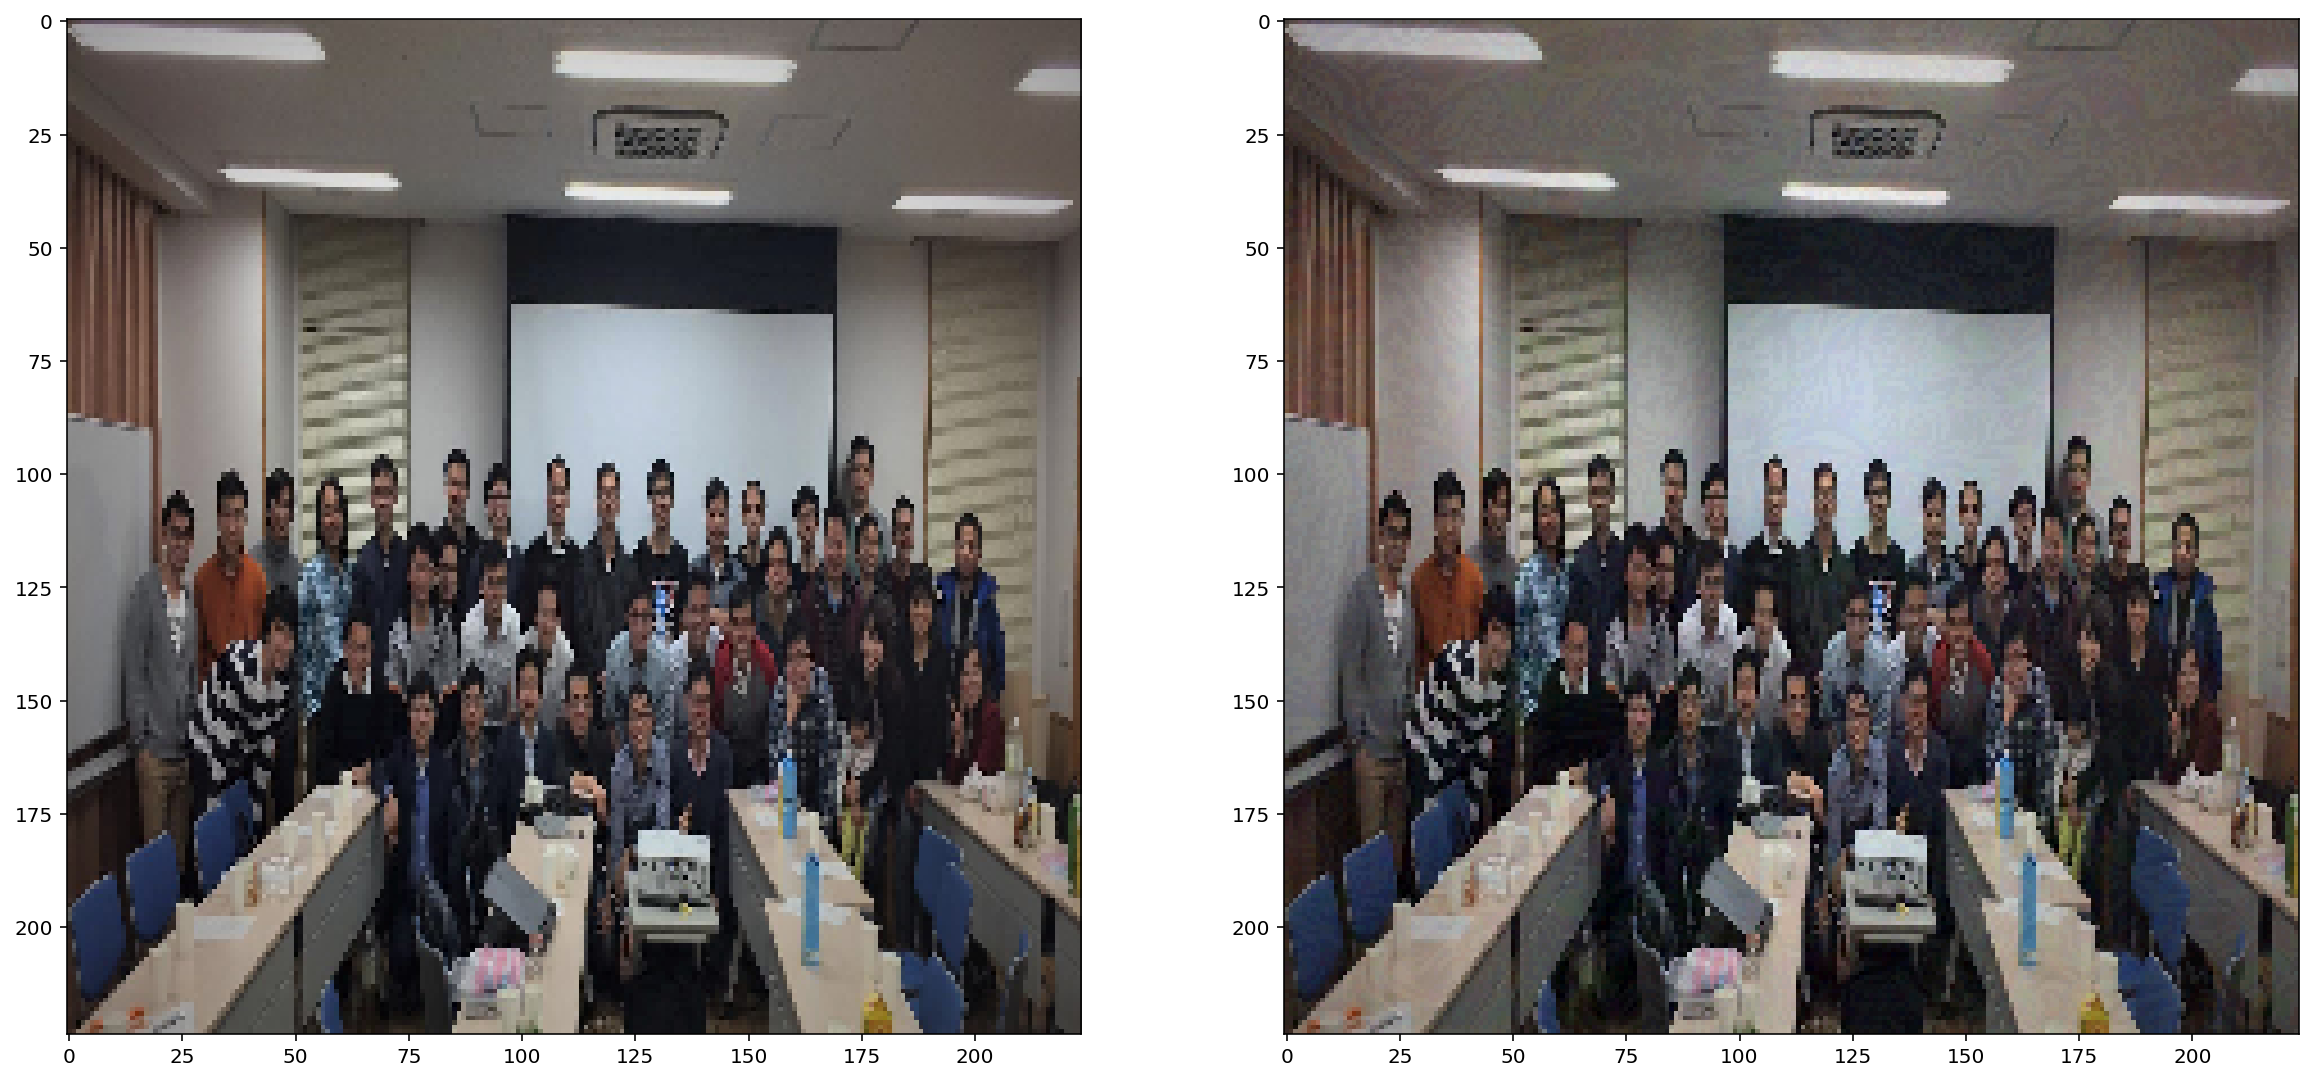

In [8]:
f, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].imshow((img_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((adversarial_img)[0].detach().numpy().transpose(1,2,0))

In [9]:
print('Original class: ', imagenet_classes[predit_id])
print('Original class probability: {}'.format(nn.Softmax(dim=1)(adv_pred)[0,predit_id].item()))
new_adv_predict_id = adv_pred.max(dim=1)[1].item()
print('New predict class: ', imagenet_classes[new_adv_predict_id])
print('New predict class probability: ', nn.Softmax(dim=1)(adv_pred)[0, new_adv_predict_id].item())

Original class:  balance_beam
Original class probability: 2.718519020790145e-43
New predict class:  restaurant
New predict class probability:  1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

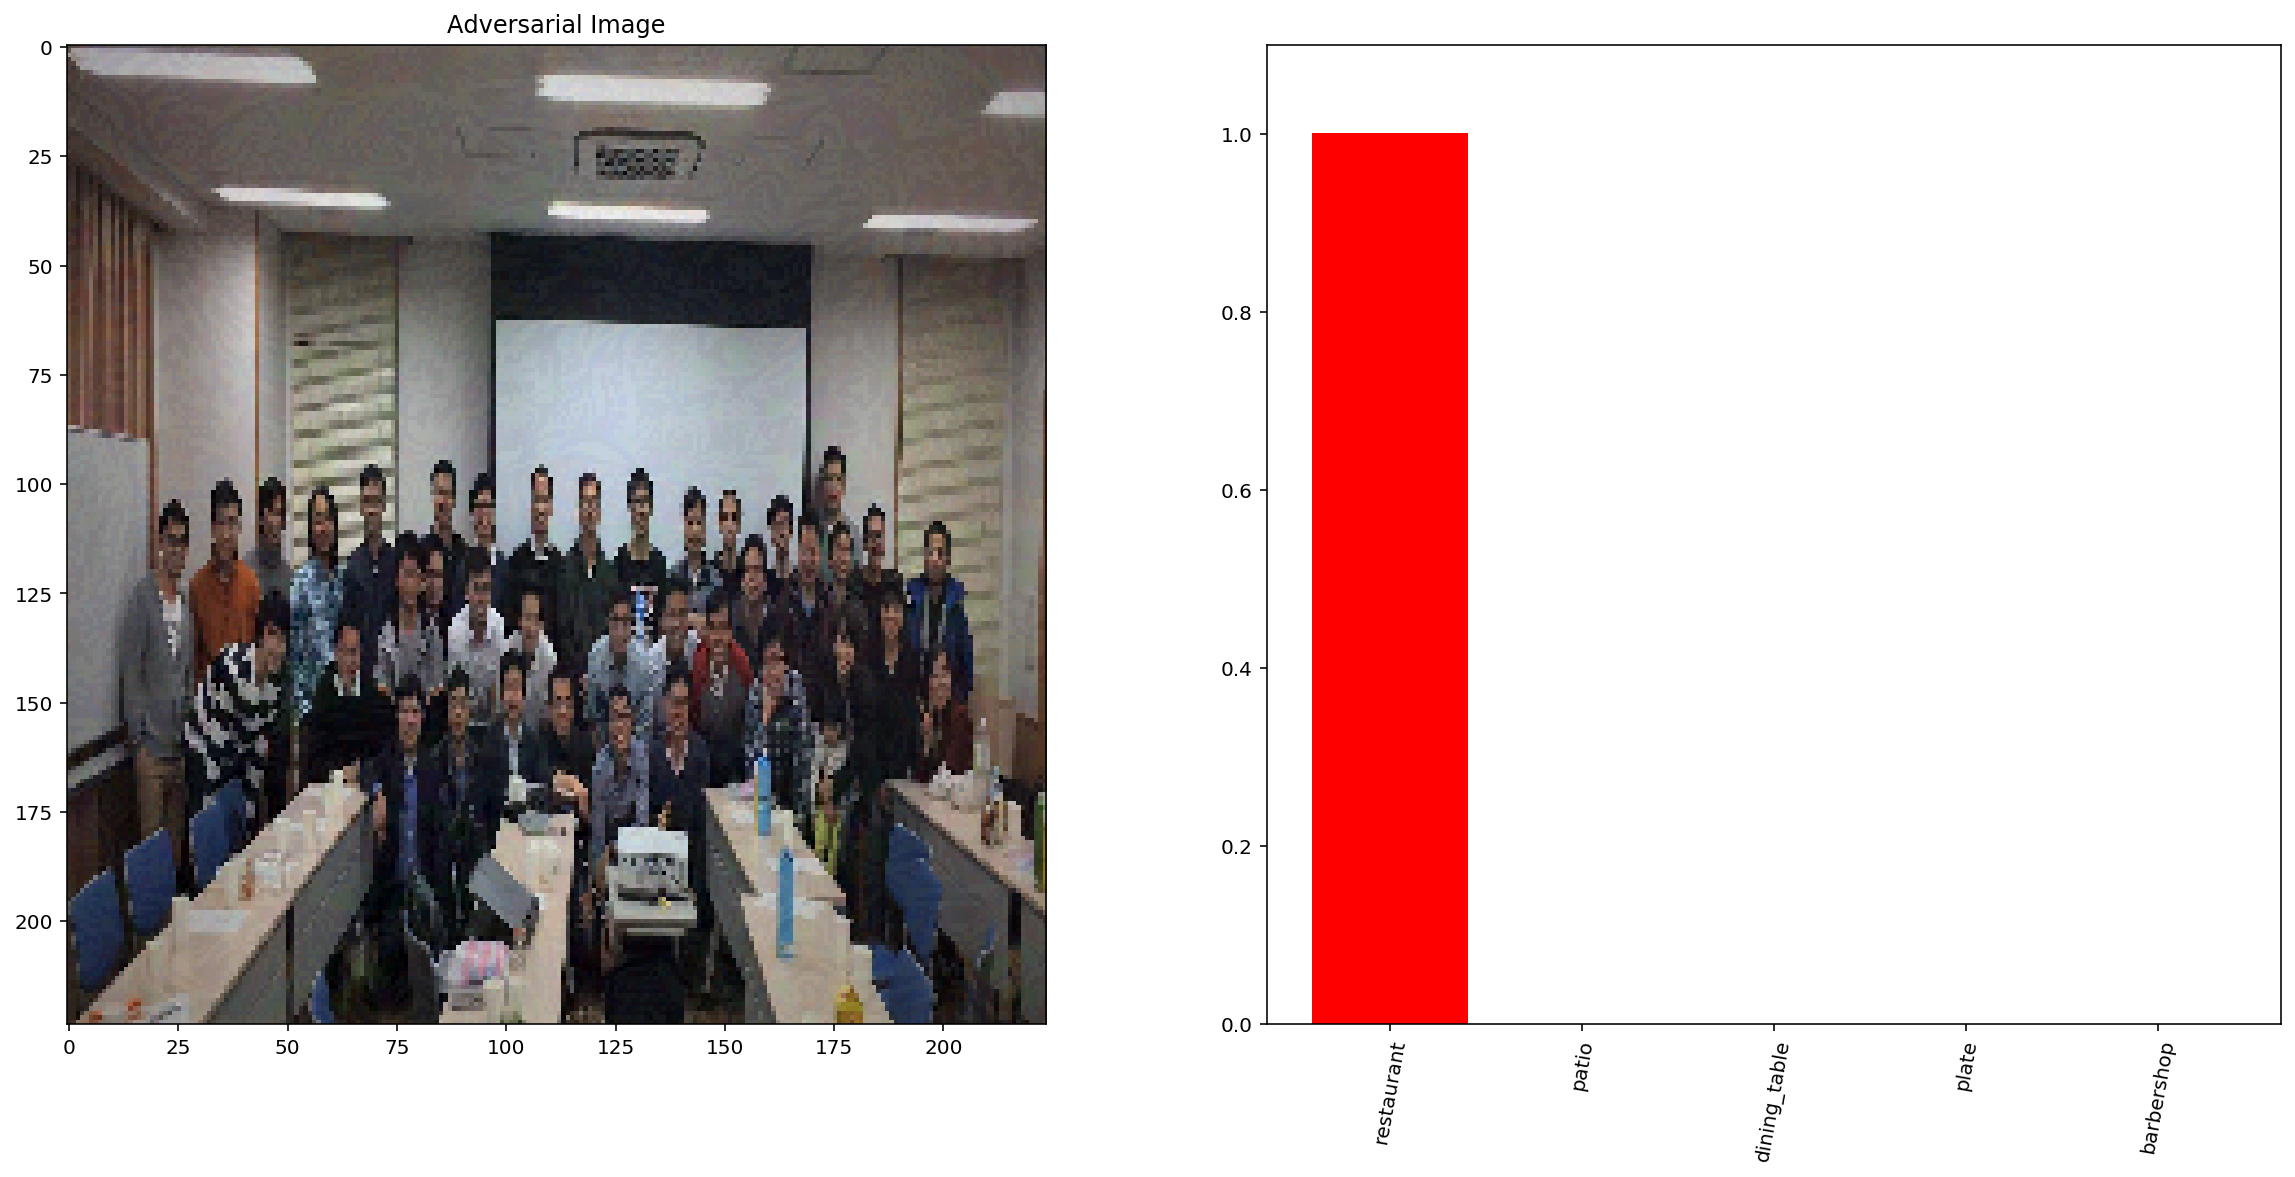

(762, 1.0)

In [10]:
plot_figure(adversarial_img, adv_pred, correct_class=predit_id, target_class=new_adv_predict_id, pars=None, img_name='Adversarial Image')

In [ ]:
from torchvision.models import densenet161
model = densenet161(pretrained=True)
model.eval()
new_pred = model(norm(adversarial_img))
new_predit_id = new_pred.max(dim=1)[1].item()
print('Original class: ', imagenet_classes[new_predit_id])
print('Original class probability: {}'.format(nn.Softmax(dim=1)(new_pred)[0,new_predit_id].item()))

In [ ]:
plot_figure(adversarial_img, new_pred, correct_class=predit_id, target_class=new_adv_predict_id, pars=None, img_name='Image')

## Targeted Attack

In [ ]:
model = resnet152(pretrained=True)
model.eval()

In [ ]:
epsilon = 4./255
delta = torch.zeros_like(img_tensor, requires_grad=True)
opt = optim.Adam([delta], lr=1e-3)
input_img = copy.deepcopy(img_tensor)
# id = 9: ostrich
for i in range(100):
    adv_pred = model(norm(input_img + delta))
    loss = (-nn.CrossEntropyLoss()(adv_pred, torch.LongTensor([predit_id]))
            +nn.CrossEntropyLoss()(adv_pred, torch.LongTensor([9]))
           )
    if i % 10 == 0:
        print(i, -loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
adversarial_img = input_img + delta

In [ ]:
new_adv_predict_id = adv_pred.max(dim=1)[1].item()
plot_figure(adversarial_img, adv_pred, correct_class=predit_id, target_class=new_adv_predict_id, pars=None, img_name='Adversarial Image')

In [ ]:
from torchvision.models import densenet161
model = densenet161(pretrained=True)
model.eval()
new_pred = model(norm(adversarial_img))
new_predit_id = new_pred.max(dim=1)[1].item()
print('Original class: ', imagenet_classes[new_predit_id])
print('Original class probability: {}'.format(nn.Softmax(dim=1)(new_pred)[0,new_predit_id].item()))
plot_figure(adversarial_img, new_pred, correct_class=predit_id, target_class=new_adv_predict_id, pars=None, img_name='Image')

In [ ]:
f, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].imshow((img_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((adversarial_img)[0].detach().numpy().transpose(1,2,0))

In [ ]:
from affine_demo import translation_image, rotation_image

In [ ]:
rotation_adv_img = rotation_image((adversarial_img)[0].detach().numpy().transpose(1,2,0), angle=5, img_type='color')

In [ ]:
plt.imshow(rotation_adv_img)

In [ ]:
rotation_adv_img_tensor = torch.from_numpy(rotation_adv_img.transpose(2,0,1))
rotation_adv_img_tensor = rotation_adv_img_tensor[None,:,:,:]
plt.imshow((rotation_adv_img_tensor)[0].detach().numpy().transpose(1,2,0))

In [ ]:
#model = resnet152(pretrained=True)
#model.eval()
new_pred = model(norm(rotation_adv_img_tensor))
new_predit_id = new_pred.max(dim=1)[1].item()
print('Original class: ', imagenet_classes[new_predit_id])
print('Original class probability: {}'.format(nn.Softmax(dim=1)(new_pred)[0,new_predit_id].item()))

In [ ]:
plot_figure(rotation_adv_img_tensor, new_pred, correct_class=predit_id, target_class=new_adv_predict_id, pars=None, img_name='Image')

In [ ]:
new_adv_predict_id

In [ ]:
y = rotation_adv_img_tensor[None,:,:,:]

In [ ]:
y.shape

In [ ]:
f, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].imshow((img_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow(rotation_adv_img)
#plt.imshow(rotation_adv_img_tensor[0].detach().numpy().transpose(1,2,0))